# Bài tập cuối kỳ môn Học máy
#### Sinh viên: Lê Thị Khánh Linh
#### MSSV: 24022384
#### Lớp: 2526I_INT3405#_5
#### Đề tài: *Đếm đám đông thông qua hồi quy bản đồ mật độ (Density Map Regression)*

## 1. Giới thiệu bài toán

Bài toán đếm đám đông (Crowd Counting) là một trong những bài toán thách thức trong lĩnh vực thị giác máy tính, với mục tiêu ước lượng chính xác số lượng người xuất hiện trong một ảnh tĩnh hoặc chuỗi ảnh. Khó khăn của bài toán này đến từ nhiều yếu tố phức tạp trong môi trường thực tế, bao gồm:

- **Sự thay đổi tỷ lệ (Scale Variation):** Kích thước đối tượng thay đổi đáng kể do khác biệt về khoảng cách tới camera.
- **Sự che khuất (Occlusion):** Các cá thể trong đám đông thường che lấp lẫn nhau, đặc biệt trong các cảnh có mật độ cao.
- **Mật độ phân bố không đồng đều:** Số lượng người có thể thay đổi mạnh giữa các vùng khác nhau trong cùng một ảnh.

Trong bài tập này, mô hình được cài đặt và chạy thử nghiệm đóng vai trò là một mô hình baseline nhằm minh họa quy trình suy luận (inference) và tạo cơ sở thực nghiệm. Trên cơ sở đó, báo cáo cuối kỳ sẽ tập trung vào việc nghiên cứu và so sánh (Comparative Study) các phương pháp tiêu biểu đại diện cho các giai đoạn phát triển khác nhau của bài toán đếm đám đông, dựa trên các kết quả đã được công bố chính thức trong tài liệu nghiên cứu.

**Mô hình Baseline (Mốc chuẩn): CSRNet (CVPR 2018)**

- **Vai trò:** CSRNet là đại diện tiêu biểu cho hướng tiếp cận truyền thống dựa trên mạng nơ-ron tích chập (CNN) trong bài toán Crowd Counting, thường được sử dụng như một mốc chuẩn trong nhiều nghiên cứu sau này.
- **Đặc điểm:** Mô hình sử dụng kiến trúc tích chập giãn nở (*Dilated Convolution*) kết hợp với backbone VGG-16 nhằm mở rộng vùng tiếp nhận (receptive field) mà không làm giảm độ phân giải không gian của đặc trưng. Nhờ đó, CSRNet có khả năng khai thác ngữ cảnh rộng trong ảnh, đồng thời vẫn giữ được thông tin chi tiết cần thiết cho việc hồi quy bản đồ mật độ.


## 2. Nạp thư viện

Phần này thực hiện import các thư viện cần thiết cho việc xử lý ảnh, tính toán ma trận và xây dựng mô hình Deep Learning.
Mã nguồn cũng sẽ kiểm tra tính khả dụng của GPU (CUDA) để tối ưu hóa tốc độ tính toán.

In [14]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import warnings

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings('ignore')

# Import kiến trúc mạng từ file model_arch.py
from model_arch import CSRNet

# Kiểm tra thiết bị (ưu tiên dùng GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"PyTorch Version: {torch.__version__}")
print(f"Device đang sử dụng: {device}")

PyTorch Version: 2.9.1+cpu
Device đang sử dụng: cpu


## 3. Cấu hình và Tải trọng số (Pre-trained Weights)

Mô hình sử dụng bộ trọng số đã được huấn luyện trên tập dữ liệu **ShanghaiTech Part B**. Đây là tập dữ liệu đặc thù cho các cảnh quay giám sát với mật độ người thưa và góc nhìn cao, phù hợp với các ứng dụng đếm người trong thực tế.

Hàm `load_model` dưới đây được thiết kế để nạp trọng số vào kiến trúc CSRNet, đồng thời xử lý các vấn đề không tương thích về tên biến (key mismatch) thường gặp khi chuyển đổi giữa các môi trường huấn luyện khác nhau.

In [15]:
def load_model(model_path):
    model = CSRNet().to(device)
    
    if not os.path.exists(model_path):
        print(f"Lỗi: Không tìm thấy file trọng số tại {model_path}")
        return None
        
    print(f"Đang nạp trọng số từ: {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    
    # Xử lý trường hợp file weights lưu cả thông tin optimizer
    if 'state_dict' in checkpoint:
        checkpoint = checkpoint['state_dict']
    
    # Xử lý tương thích tên biến (loại bỏ tiền tố 'module.' nếu có)
    new_state_dict = {}
    for k, v in checkpoint.items():
        name = k.replace("module.", "") 
        new_state_dict[name] = v
        
    try:
        model.load_state_dict(new_state_dict, strict=False)
        print("Nạp trọng số thành công.")
    except Exception as e:
        print(f"Cảnh báo khi nạp weights: {e}")
        
    model.eval() # Chuyển sang chế độ đánh giá (Inference Mode)
    return model

# Đường dẫn đến file weights
MODEL_PATH = './weights/csrnet_shanghaitech.pth'
model = load_model(MODEL_PATH)

Đang nạp trọng số từ: ./weights/csrnet_shanghaitech.pth
Nạp trọng số thành công.


## 4. Tiền xử lý dữ liệu (Preprocessing)

Để mô hình hoạt động chính xác, ảnh đầu vào cần được chuẩn hóa theo cùng định dạng với dữ liệu huấn luyện (ImageNet). Quy trình bao gồm:
1.  **ToTensor:** Chuyển đổi ảnh sang dạng Tensor và chuẩn hóa giá trị pixel về đoạn [0, 1].
2.  **Normalize:** Chuẩn hóa theo Mean và Std của bộ dữ liệu ImageNet.

In [16]:
# Định nghĩa pipeline xử lý ảnh
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

def process_image(img_path):
    img_raw = Image.open(img_path).convert('RGB')
    img_tensor = transform(img_raw).unsqueeze(0) # Thêm chiều batch -> (1, 3, H, W)
    return img_raw, img_tensor.to(device)

## 5. Thực nghiệm và Trực quan hóa kết quả

Phần này thực hiện chạy mô hình trên các ảnh mẫu trong thư mục `samples/` nhằm mục đích minh họa khả năng suy luận của mô hình. Kết quả được hiển thị trực quan bao gồm:
* **Ảnh gốc:** Ảnh đầu vào.
* **Bản đồ mật độ (Density Map):** Biểu diễn sự phân bố của đám đông.
* **Số lượng ước tính:** Tổng tích phân của bản đồ mật độ.

Tìm thấy 3 ảnh. Bắt đầu xử lý...



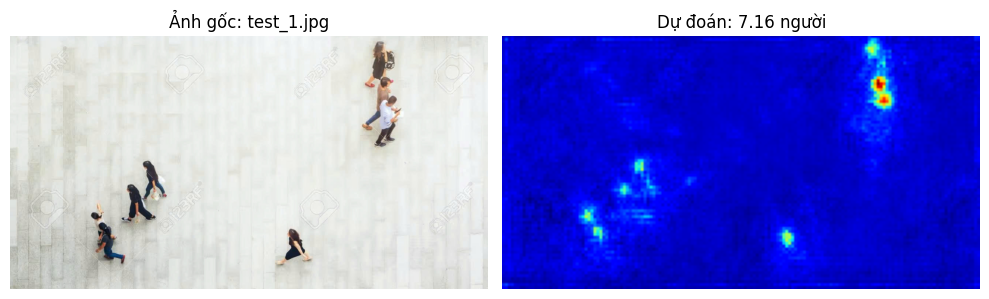

--------------------------------------------------


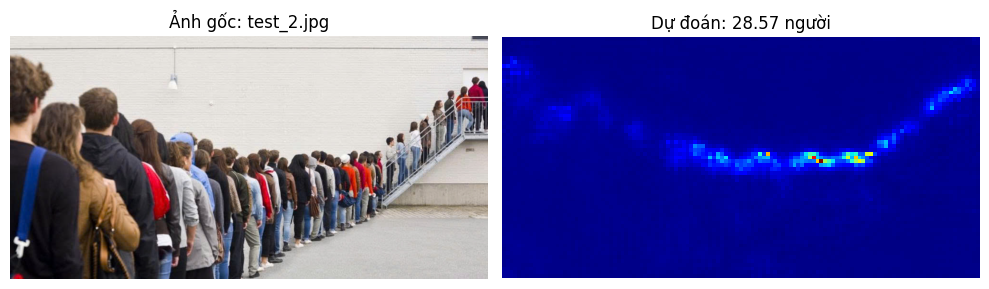

--------------------------------------------------


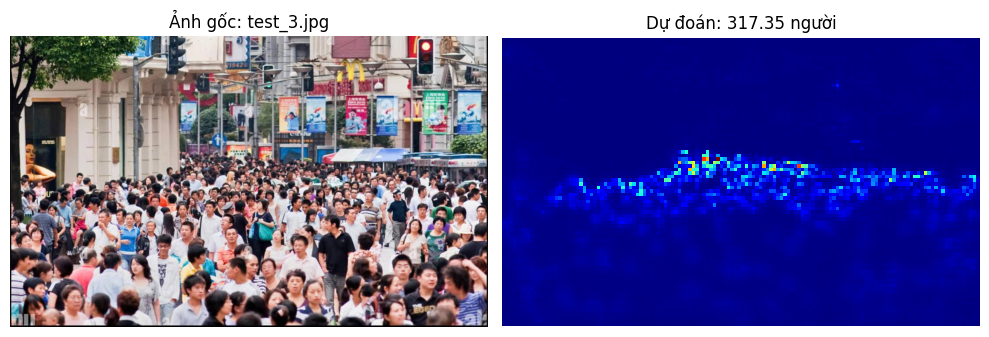

--------------------------------------------------


In [17]:
# Thư mục chứa ảnh test
SAMPLE_DIR = './samples'

# Lấy danh sách ảnh
img_files = [f for f in os.listdir(SAMPLE_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

if len(img_files) == 0:
    print("Thư mục samples đang rỗng.")
else:
    print(f"Tìm thấy {len(img_files)} ảnh. Bắt đầu xử lý...\n")

    for img_name in img_files:
        path = os.path.join(SAMPLE_DIR, img_name)
        
        # 1. Xử lý ảnh
        img_raw, img_tensor = process_image(path)
        
        # 2. Dự đoán
        with torch.no_grad():
            output = model(img_tensor)
            
        # 3. Lấy kết quả
        density_map = output.detach().cpu().numpy()[0][0]
        count = np.sum(density_map)
        
        # 4. Vẽ biểu đồ
        plt.figure(figsize=(10, 4))
        
        # Ảnh gốc
        plt.subplot(1, 2, 1)
        plt.imshow(img_raw)
        plt.title(f"Ảnh gốc: {img_name}")
        plt.axis('off')
        
        # Heatmap
        plt.subplot(1, 2, 2)
        plt.imshow(density_map, cmap='jet')
        plt.title(f"Dự đoán: {count:.2f} người")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        print("-" * 50)

## Nhận xét kết quả thử nghiệm với mô hình CSRNet (CVPR 2018)

Sau khi tiến hành chạy thử mô hình CSRNet với trọng số huấn luyện sẵn trên một số ảnh mẫu có mật độ người khác nhau, có thể rút ra một số nhận xét sau:

### 1. Khả năng ước lượng số lượng người
Mô hình CSRNet cho kết quả dự đoán số lượng người ở mức hợp lý và nhất quán với trực quan của ảnh đầu vào.  
- Với các ảnh có mật độ thấp (ví dụ `test_1.jpg`), mô hình dự đoán số người nhỏ và phân bố điểm mật độ tương đối chính xác tại các vị trí có người.
- Với ảnh có mật độ trung bình (`test_2.jpg`), CSRNet thể hiện khả năng nắm bắt tốt cấu trúc đám đông kéo dài, cho ra kết quả dự đoán tương đối ổn định.
- Đối với ảnh có mật độ cao (`test_3.jpg`), mô hình vẫn duy trì khả năng ước lượng tổng số người ở quy mô lớn, cho thấy tính tổng quát tốt của phương pháp hồi quy bản đồ mật độ.

### 2. Chất lượng bản đồ mật độ (Density Map)
Bản đồ mật độ sinh ra bởi CSRNet thể hiện rõ các vùng tập trung đông người, với cường độ cao tại những khu vực có mật độ lớn. Việc sử dụng tích chập giãn nở (dilated convolution) giúp mô hình mở rộng vùng tiếp nhận (receptive field) mà không làm mất độ phân giải không gian, từ đó giữ được cấu trúc tổng thể của đám đông.

Tuy nhiên, ở các ảnh có mật độ rất cao, bản đồ mật độ có xu hướng bị làm mượt (over-smoothing), dẫn đến việc khó phân biệt ranh giới cá thể người. Điều này phản ánh hạn chế cố hữu của các mô hình CNN thuần túy khi xử lý các kịch bản đám đông cực kỳ dày đặc.

### 3. Đánh giá tổng quan
Nhìn chung, CSRNet là một mô hình baseline mạnh và ổn định cho bài toán đếm đám đông, đặc biệt hiệu quả trong các kịch bản có mật độ từ thấp đến trung bình. Kết quả thử nghiệm cho thấy mô hình vẫn giữ được giá trị tham chiếu quan trọng, dù đã xuất hiện nhiều phương pháp SOTA mới sử dụng Transformer hoặc các cơ chế học phân phối tiên tiến hơn.

Những hạn chế quan sát được trong các cảnh có mật độ rất cao cũng là động lực thúc đẩy sự ra đời của các mô hình SOTA sau này, nhằm cải thiện khả năng thích ứng với biến đổi tỷ lệ và mật độ phức tạp trong bài toán Crowd Counting.

*Cần lưu ý rằng các kết quả trên mang tính minh họa định tính, không đại diện cho đánh giá định lượng chuẩn trên toàn bộ tập dữ liệu.*